In [ ]:
import os, sys
import importlib

from utils import load, vis, models, models_LSTM, process

In [ ]:
data_folder = "data/simplified/"
afg2 = map(lambda x : data_folder + x + '.csv', load.classes)

In [ ]:
# Set training and test sets size
batch_size = 4
steps = int(10 * 16/batch_size)
test_size = int(1000*16/batch_size)

In [ ]:
# initialize generator
data = process.SeqGenerator(afg2,100,batch_size)
gen2 = data.generateSeq()

In [ ]:
# compile model
importlib.reload(models_LSTM)
model2 = models_LSTM.DoodleLSTM((None,3), data.n_classes)
model2.compile(optimizer = 'adam', loss = 'categorical_crossentropy',metrics=['accuracy'])
model2.summary()

In [ ]:
# train model
history = model2.fit_generator(generator=gen2, epochs=640, steps_per_epoch=steps)

In [ ]:
# test model
model2.evaluate_generator(generator = gen2, steps = test_size)

In [ ]:
# serialize model to JSON
model_json = model2.to_json()
with open("modelLSTM_16dp1.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model2.save_weights("modelLSTM_16dp1.h5")
print("Saved model to disk")

In [ ]:
# save training history
import json
with open('16dp1_history.json', 'w') as f:
    json.dump(history.history, f)

In [ ]:
# plot training accuracy history
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.savefig('32vanilla_acc')
plt.show()


In [ ]:
# plot training loss history
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.savefig('32vanilla_loss')
plt.show()

In [ ]:
from keras.models import model_from_json
# load json and create model
json_file = open('modelLSTM_32dp1.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("modelLSTM_32dp1.h5")
print("Loaded model from disk")

In [ ]:
loaded_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',metrics=['accuracy'])
loaded_model.summary()

In [ ]:
loaded_model.fit_generator(generator=gen2, epochs=200, steps_per_epoch=10)

In [ ]:
loaded_model.evaluate(x_test,y_test,verbose = 0)

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

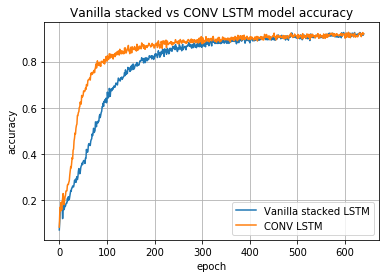

In [4]:
loaded_history = pd.read_json('16vanilla_history.json')
loaded_history2 = pd.read_json('16dp1_history.json')
#loaded_history3 = pd.read_json('8vanilla_history.json')
plt.plot(loaded_history['acc'])
plt.plot(loaded_history2['acc'])
#plt.plot(loaded_history3['acc'])
#plt.axhline(y=0.94, color='b', linestyle='--')
plot_name = 'Vanilla stacked vs CONV LSTM'
plt.title(plot_name + ' model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid()
#plt.legend(['32 classes (0.918 test accuracy)','16 classes (0.919 test accuracy)','8 classes (0.939 test acc)'])
plt.legend(['Vanilla stacked LSTM','CONV LSTM'])
plt.savefig('16_vs_acc')
plt.show()
#print(max(loaded_history['acc']))


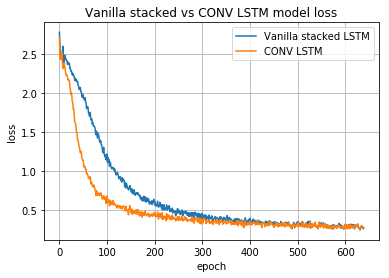

In [5]:
plt.plot(loaded_history['loss'])
plt.plot(loaded_history2['loss'])
#plt.plot(loaded_history3['loss'])
#plt.axhline(y=0.94, color='b', linestyle='--')
plot_name = 'Vanilla stacked vs CONV LSTM'
plt.title(plot_name + ' model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
#plt.legend(['32 classes','16 classes','8 classes'])
plt.legend(['Vanilla stacked LSTM','CONV LSTM'])
plt.savefig('16_vs_loss')
plt.show()
#print(max(loaded_history['acc']))

## Generate correct and incorrect examples

In [ ]:
import numpy as np
x_test,y_test = next(gen2)
for i in range(99):
    x,y = next(gen2)
    x_test = np.concatenate((x_test,x),axis = 0)
    y_test = np.concatenate((y_test,y),axis = 0)
validate = (x_test,y_test)

In [ ]:
# Test results
y_model = loaded_model.predict_classes(x_test)
# True Labels
y_true = np.argmax(y_test,axis =1)

In [ ]:
y_true = np.argmax(y_test,axis =1)

Storing correct and incorrect classification results

In [ ]:
# Storing correct and incorrect classification results
count_cor = 0
count_inc = 0
correct = []
incorrect = []
lbl_cor = []
inc_lbl_true = []
inc_lbl_model = []
idx = 0
for i in range(y_model.shape[0]):
    if y_model[i] == y_true[i]:
        correct.append(i)
        lbl_cor.append(y_model[i])
        count_cor += 1
    elif y_model[i] != y_true[i] and count_inc < 5:
        incorrect.append(i)
        inc_lbl_true.append(y_true[i])
        inc_lbl_model.append(y_model[i])
        count_inc += 1

In [ ]:
# classes used
classes_1 = ["airplane","angel","basket","bear","belt","candle","crown","cat"]
classes_2 = ['bee','crab','drums','elephant','hospital','mouse','onion','tree']
classes_3 = ['book', 'camel', 'camera', 'carrot', 'matches', 'microwave', 'nose', 'toaster']
classes_4 = ['apple','cloud', 'dresser', 'drill','mug', 'pool', 'submarine', 'toilet']
classes = classes_1 + classes_2 + classes_3 + classes_4

In [ ]:
def sketchplot(data,row):
    xy = data[row]
    x = xy[:,0]
    y = xy[:,1]
    return x,y

In [ ]:
# Plot correct examples
idx = 1
true = classes[lbl_cor[idx]]
x,y = sketchplot(x_test,correct[idx])
plt.plot(x, y, marker='.')
plt.title('True/Classified label = ' + true)
plt.axis('off')
plt.savefig('Correct_'+true)

In [ ]:
# Plot incorrect examples
idx = 1
true = classes[inc_lbl_true[idx]]
our_model = classes[inc_lbl_model[idx]]
x,y = sketchplot(x_test,incorrect[idx])
plt.plot(x, y, marker='.')

plt.title('True label = ' + true+'; Classified as '+our_model)
plt.axis('off')
plt.savefig('should_be_'+true+'_but_'+our_model)